# Hackathon #1

Written by Eleanor Quint

Topics:
- The basic unit of computation, the Tensor and operations
- How to create and optimize trainable Variables
- Gradient descent optimization

This is all setup in a IPython notebook so you can run any code you want to experiment with. Feel free to edit any cell, or add some to run your own code.

In [ ]:
# We'll start with our library imports...
from __future__ import print_function

import numpy as np  # to use numpy arrays
import tensorflow as tf  # to specify and run computation graphs

In [ ]:
tf.config.list_physical_devices('GPU') 

### Tensor

The basic unit of data in TensorFlow is the [`tf.Tensor`](https://www.tensorflow.org/api_docs/python/tf/Tensor). A tensor is a multi-dimensional array of numerical variable specialized for numerical computation with an underlying data type (think `float` or `int`). Here are some examples of tensors we'll create with [`tf.convert_to_tensor`](https://www.tensorflow.org/api_docs/python/tf/convert_to_tensor), or [`tf.ones`](https://www.tensorflow.org/api_docs/python/tf/ones) or `tf.zeros` (which have the same interface).

In [ ]:
# a 0-dim tensor; a scalar with shape ()
its_complicated = tf.convert_to_tensor(12.3 - 4.85j, tf.complex64)
print(its_complicated)
print()

# a 1-dim tensor; a vector with shape (5,), meaning it's just a plain 'ol array
# notice that we've given a name to this variable
first_primes = tf.convert_to_tensor(np.array([2, 3, 5, 7, 11], np.int32), name="primes")
print(first_primes)
print()

# a 2-dim tensor; a matrix with shape [2, 3]
# notice that the dtype is inferred when we don't specify it
my_identity = tf.ones([2, 3])
print(my_identity)
print(
    "We can retrieve a numpy array from TensorFlow:",
    my_identity.numpy(),
    "is a",
    type(my_identity.numpy()),
)
print()

# a 4-dim tensor with shape [10, 299, 299, 3]
blank_image = tf.zeros([10, 299, 299, 3])
print("tf.shape returns a Tensor:", tf.shape(blank_image))
print("while .shape returns a tuple:", blank_image.shape)

#### Tensor Shape and Broadcasting

The shape of a tensor can be checked by calling the [tf.shape](https://www.tensorflow.org/api_docs/python/tf/shape) operation. (Note too that the dimension can be checked with `len(x.shape)`). Tensors can be reshaped with [tf.reshape](https://www.tensorflow.org/api_docs/python/tf/reshape). For example:

In [ ]:
print(tf.range(10))
print()
print(tf.reshape(tf.range(10), (2, 5)))  # re-arrange into two rows
print()
print(tf.reshape(tf.range(10), (1, 10)))  # add a dimension

The shape of a tensor is important to determine what operations are valid on it. TensorFlow uses the same operational semantics and broadcasting rules as numpy. Operations are generally pointwise, as illustrated by the following multiplication which calculates squares.

In [ ]:
print(
    "Shapes",
    tf.range(10).shape,
    "and",
    tf.range(10).shape,
    "gives",
    (tf.range(10) * tf.range(10)),
)

Scalars with shape `()` can always be broadcast to operate with anything

In [ ]:
print(
    "Shapes",
    tf.range(10).shape,
    "and",
    tf.convert_to_tensor(2).shape,
    "gives",
    (tf.range(10) - tf.convert_to_tensor(2)),
)

And similarly, if one of the tensors has a 1 in a dimension and the other doesn't, broadcasting occurs in that dimension. You can assume all tensors' shape begin with an implicit 1, which allows the last example below to work.

In [ ]:
# these operation will fail if uncommented
# tf.range(10) * tf.range(20)
# tf.ones([2,10]) * tf.ones([3,10])

# note that tf.ones([a,b]) == tf.reshape(tf.ones(a*b), [a,b])
print(
    "This example broadcasts in the first two dimensions to get shape:",
    (tf.ones([3, 1, 10]) * tf.ones([1, 3, 10])).shape,
)
print(
    "This one works because the first has implicit shape [1,10], giving shape:",
    (tf.range(10) * tf.ones([2, 10], dtype=tf.int32)).shape,
)

#### Tensor data type

Broadcasting gives a good amount of flexibility to working with shapes, but TensorFlow will never implicitly change data types, leading to hidden errors like the one below. Changing the data type is easy with `tf.cast`.

In [ ]:
# This won't work, even though the shapes line up: tf.range(10) * tf.ones([2,10])
# Why?
print("First type is", tf.range(10).dtype, "and second is", tf.ones([2, 10]).dtype)
print("This works though!", tf.range(10) * tf.cast(tf.ones([2, 10]), tf.int32))

### Trainable variables

In machine learning, we're interested in using models which are parameterized with trainable variables. We can create variables with `tf.Variable` and by providing the initial value.

In [ ]:
print(tf.Variable(tf.random.normal([10])))

We can use TensorFlow's autodifferentiation, which tracks operations for you and automatically backpropagates gradients when requested. This tracking happens in the context of a [`tf.GradientTape`](https://www.tensorflow.org/api_docs/python/tf/GradientTape) and gradients are calculated by a call to `tf.GradientTape.gradient`.

In [ ]:
x = tf.Variable(3.0)
with tf.GradientTape() as tape:
    y = x ** 2  # calculate x^2

# Call gradient with output value(s) and variable(s)
grad = tape.gradient(y, x)

print(grad)  # we expect this to be 2*x

#### Gradient descent optimization

Next, we're going to take a big step to using gradient descent to solve a system of linear equations, `Ax=b`, like you might see in a linear algebra class. We'll generate fixed values for A and b, and make `x` a variable we can learn. Then, we'll calculate an error function (the `difference_sq` line below), and use the gradients of the error with respect to `x` to update it to make the error smaller on the next run. We can do this for all the indices of the `x` vector simultaneously.

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np  # to use numpy arrays
import tensorflow as tf  # to specify and run computation graphs
plt.style.use("seaborn-darkgrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
sns.set(rc={'axes.facecolor':'darkgrey', 'figure.facecolor':'darkgrey'})
# plt.style.use('dark_background')

In [ ]:


learning_rate = 0.5
num_iterations = 50

# the optimizer allows us to apply gradients to update variables
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Create a fixed matrix, A
# A = tf.random.normal([4, 4])
A = tf.convert_to_tensor(tf.constant([
	[1,4,1,2],
	[3,2,5,6],
	[5,1,1,2],
	[2,5,3,4]
], tf.float32), name="primes")
# Create x using an arbitrary initial value
x = tf.Variable(tf.ones([4, 1]))
# Create a fixed vector b
# b = tf.random.normal([4, 1])
b = tf.convert_to_tensor(tf.constant([2,3,2,4], tf.float32), name="banana")

# Check the initial values
print("A:", A.numpy())
print("b:", b.numpy())

print("Initial x:", x.numpy())
print("Ax:", (A @ x).numpy())
print()

error = []

# We want Ax - b = 0, so we'll try to minimize its value
for step in range(num_iterations):
    print("Iteration", step)
    with tf.GradientTape() as tape:
        # Calculate A*x
        product = tf.matmul(A, x)
        # calculat the loss value we want to minimize
        # what happens if we don't use the square here?
        difference_sq = tf.math.square(product - b)
        error.append(tf.norm(tf.math.sqrt(difference_sq)).numpy())
        print("Squared error:", error[-1])
        # calculate the gradient
        grad = tape.gradient(difference_sq, [x])
        # print("Gradients:")
        # print(grad)
        # update x
        optimizer.apply_gradients(zip(grad, [x]))
        # print()

# Check the final values
print("Optimized x", x.numpy())
print("Ax", (A @ x).numpy())  # Should be close to the value of b

In [ ]:
# [2,3,2,4]

# 0.01 500
# 3.673455

# 0.01 5000
# 3.4764342

# 0.1 500
# 3.5617592

# 0.1 5000
# 3.3166246

# 0.25 500
# 3.4844558

# 0.25 5000
# 3.3166246

# 0.5 500
# 3.4103253

# 0.5 5000
# 3.3166246

print(error[-1])
sns.lineplot(error)

We use `.numpy()` to get the value of the tensor for a cleaner output message. If the number of iterations is large enough, we will eventually learn a vector for `x` which approximately satisfies the system of equations.

### Homework

Your homework is to specify a simple optimization problem that you will solve with gradient descent (as above). Then, play around with the learning rate and number of update iterations to get an intuitive understanding of how they affect your solver. Write up a paragraph describing your equation, how learning rate and number of iterations gave a better or worse solution, and with your intuition for why. Submit this writeup in a `.pdf` with a `.py` of your code.

I'm expecting this to take about an hour (or less if you're experienced). Feel free to use any code from this or previous hackathons. If you don't understand how to do any part of this or if it's taking you longer than that, please let me know in office hours or by email (both can be found on the syllabus). I'm also happy to discuss if you just want to ask more questions about anything in this notebook!

In [2]:
from __future__ import print_function

import numpy as np  # to use numpy arrays
import tensorflow as tf  # to specify and run computation graphs
from matplotlib import pyplot as plt
import seaborn as sns
from math import sqrt
import random
from itertools import product

plt.style.use("seaborn-darkgrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
sns.set(rc={'axes.facecolor':'darkgrey', 'figure.facecolor':'darkgrey'})

tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:




def larn(params):
	random.seed(42)

	learning_rate, num_iterations = params
	# the optimizer allows us to apply gradients to update variables
	optimizer = tf.keras.optimizers.Adam(learning_rate)

	# Create a fixed matrix, A
	# A = tf.random.normal([4,4])
	A = tf.convert_to_tensor(tf.constant([
		[3,4,7,3],
		[3,6,8,9],
		[7,5,8,2],
		[6,3,8,5]
	], tf.float32), name="a num")

	# B = tf.random.normal([4,4])

	B = tf.convert_to_tensor(tf.constant([
		[1,4,1,2],
		[3,2,5,6],
		[5,1,1,2],
		[2,5,3,4]
	], tf.float32), name="b num")

	# Create x using an arbitrary initial value
	# x = tf.convert_to_tensor(tf.constant([[2],[3],[2],[4]], tf.float32), name="aa")
	x = tf.Variable(tf.ones([4,1]))
	y = tf.Variable(tf.ones([4,1]))
	# Create a fixed vector b
	# b = tf.random.normal([4,1])
	# c = tf.random.normal([4,1])

	c = tf.convert_to_tensor(tf.constant([2,3,2,4], tf.float32), name="banana")

	# Check the initial values
	# print("A:", A.numpy())
	# print("B:", B.numpy())
	# print("c:", c.numpy())

	# print("Initial x:", x.numpy())
	# print("Ax:", (A @ x).numpy())
	# print("Bx:", (B @ y).numpy())
	# print()
	# print("Ax^2", ((A @ x)**2).numpy())
	# print("Bx^2", ((B @ y)**2).numpy())
	# print()
	# print("sqrt( (xA)^2 + (xB)^2 )", tf.sqrt( (A @ x)**2 + (B @ y)**2 ).numpy())

	error = []

	# We want sqrt( (xA)^2 + (yB)^2 ) - C = 0, so we'll try to minimize its value
	for step in range(num_iterations):
		# print("Iteration", step)
		with tf.GradientTape() as tape:
			# Calculate A*x
			product = tf.sqrt( (A @ x)**2 + (B @ y)**2 )
			# calculat the loss value we want to minimize
			# what happens if we don't use the square here?
			difference_sq = tf.math.square(product - c)
			error.append(tf.norm(tf.math.sqrt(difference_sq)).numpy())
			# print("Squared error:", error[-1])
			# calculate the gradient
			grad = tape.gradient(difference_sq, [x,y])
			# print("Gradients:")
			# print(grad)
			# update x
			optimizer.apply_gradients(zip(grad, [x,y]))
			# print()
	return error

# Check the final values
# print("Optimized x", x.numpy())
# print("Optimized y", y.numpy())
# print("c", c.numpy())
# print("sqrt( (xA)^2 + (xB)^2 )", tf.sqrt( (A @ x)**2 + (B @ y)**2 ).numpy())  # Should be close to the value of b

In [4]:

l_rate = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75]
num_i = [10, 50, 100, 500, 1000]
form = list(product(l_rate, num_i))

plt.figure(figsize=(30,40), dpi=100)
e = [[],[],[],[],[]]
sns.set(rc={"figure.figsize":(8, 4)})
for index, item in enumerate(form):
    e[index%5].append(larn(item))
# sns.lineplot(e)

# sns.lineplot(error)

<Figure size 3000x4000 with 0 Axes>

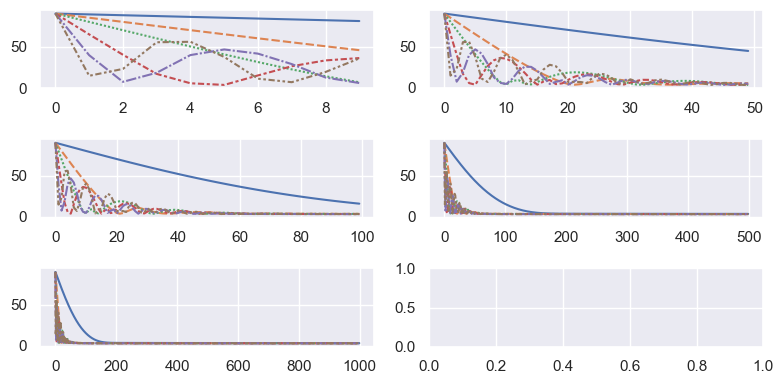

In [5]:
# plt.legend([],[], frameon=False)
fig, axs = plt.subplots(3,2)
# for ax in axs:
# axs.get_legend().remove()
for i, a in enumerate(e):
	sns.lineplot(a, ax=axs[i//2,i%2], legend=None)
